In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from resources import load_data, custom_k_fold_split, standardize_data
from tqdm import tqdm

def custom_F1_weighted(y_test, predictions):
    return f1_score(y_test, predictions, average='weighted', zero_division=0)

def custom_mean_squared_error(y_test, predictions):
    return np.mean((y_test-predictions)**2)

def fit_and_evaluate_model(model, X, y, metric: list[callable] = custom_F1_weighted, random_state=100):
    metric_list = [[] for _ in range(len(metric))]
    for fold in custom_k_fold_split(X, y, method='individual', random_state=random_state):
        X_train, X_test, y_train, y_test = fold
        X_train, X_test = standardize_data(X_train, X_test)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        for i, cur_metric in enumerate(metric):
            metric_list[i].append(cur_metric(y_test, predictions))
    return metric_list

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0).reset_index(drop=True)
        df.sample(n_samples, replace=True).to_csv('data/HR_data_bootstrapped.csv', index=False)
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def repeat_dataset(num_iterations):
    sets = []
    for i in range(num_iterations):
        X, y = load_data('data/HR_data.csv')
        sets.append((X, y))
    return sets

def no_resample():
    X, y = load_data('data/HR_data.csv')
    return [(X, y)]

def bootstrap_evaluation(model, sets, metric: list[callable] = custom_F1_weighted):
    bootstrap_results = {
        'metric': [[] for _ in range(len(metric))]
    }

    for i, (X, y) in tqdm(enumerate(sets), desc=str(model).split('.')[-1].split("\'")[0], total=len(sets)):
        model_ = model()
        ## random_state is set to 100 + i to ensure different random states for each iteration
        metric_ = fit_and_evaluate_model(model_, X, y, metric=metric, random_state=100 + i) 
        for i, cur_metric in enumerate(metric_):
            bootstrap_results['metric'][i].append(cur_metric)

    list_of_metrics = [[] for _ in range(len(metric))]
    for i, cur_metric in enumerate(bootstrap_results['metric']):           
        for round in cur_metric:
            for val in round:
                list_of_metrics[i].append(val)
    return list_of_metrics

In [11]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

_METRIC_ = custom_mean_squared_error
_METRIC_NAME_ = 'MSE'

_METRIC2_ = custom_F1_weighted
_METRIC2_NAME_ = 'F1'

metric_list = [_METRIC_, _METRIC2_]

# data = custom_resample(20, 1000)
data = repeat_dataset(100)

acc, rff1 = bootstrap_evaluation(RandomForestClassifier, data, metric=metric_list)
nb_acc, nbf1 = bootstrap_evaluation(GaussianNB, data, metric=metric_list)
svc_acc, svcf1 = bootstrap_evaluation(SVC, data, metric=metric_list)
nn_acc, nnf1 = bootstrap_evaluation(lambda: MLPClassifier(max_iter=1000), data, metric=metric_list)
base_acc, basef1 = bootstrap_evaluation(Baseline, data, metric=metric_list)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
metrics = [acc, nb_acc, svc_acc, nn_acc, base_acc]
f1_list = [rff1, nbf1, svcf1, nnf1, basef1]
metric_iterators = zip(models, metrics, f1_list)

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))
print(np.mean(rff1), np.mean(nbf1), np.mean(svcf1), np.mean(nnf1), np.mean(basef1))

import pickle
for model, metric in zip(models, metrics):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(metric, f)

Baseline: 100%|██████████| 100/100 [00:05<00:00, 16.71it/s]

Random Forest Naive Bayes SVC MLP Baseline
4.1049404761904755 7.208333333333333 4.619047619047619 4.242142857142857 5.351190476190475
0.18294627561591847 0.14988050970193828 0.14529306672163814 0.18893970843970842 0.14482422339565199


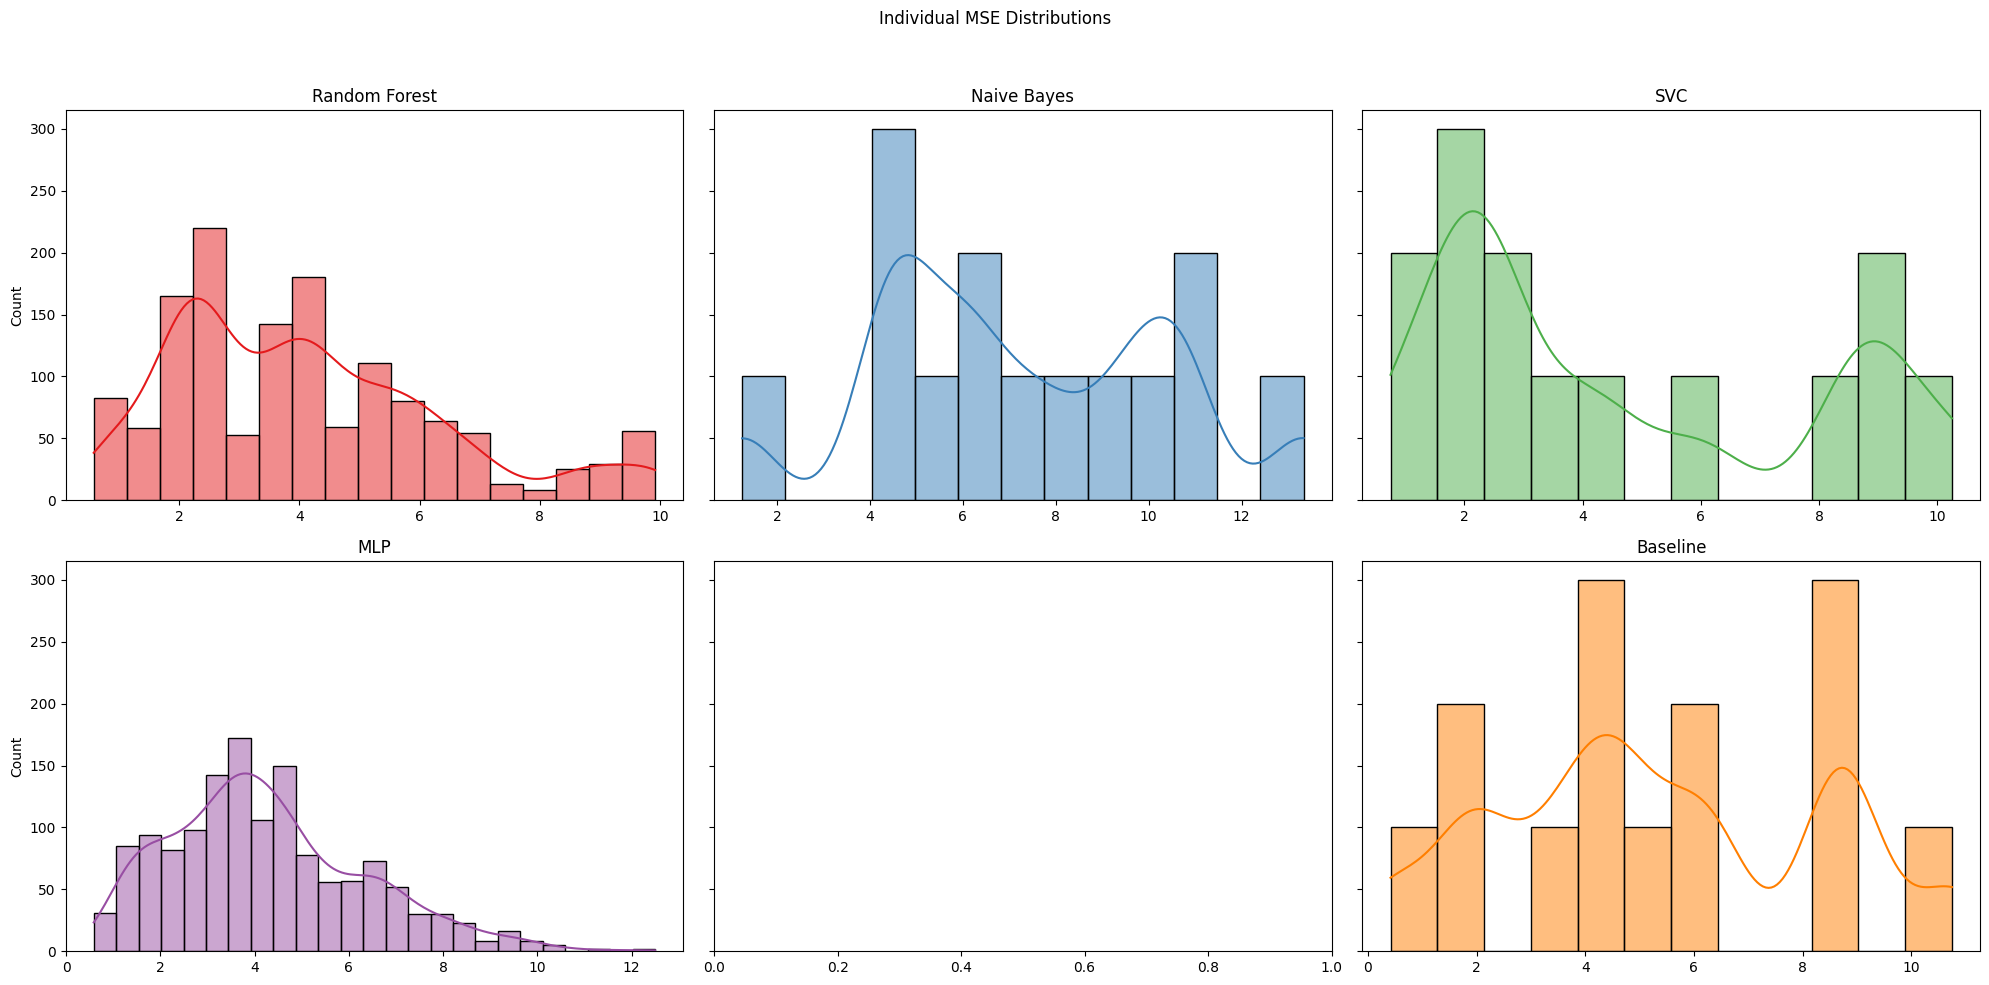

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette('Set1', n_colors=5)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)

for i, (model, metric, color, ax) in enumerate(zip(models, metrics, colors, axs.flatten())):
    if i == 4: ax = axs.flatten()[i+1]
    sns.histplot(metric, color=color, kde=True, label=model, ax=ax)
    ax.set_title(model) 


fig.suptitle(f'Individual {_METRIC_NAME_} Distributions')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the main title

plt.savefig(f'plots/individual_{_METRIC_NAME_}_dists.png')
plt.show()

Random Forest - Shapiro-Wilk Test Statistic: 0.937090763391585
Random Forest - Shapiro-Wilk Test p-value: 7.055833963927674e-24
Random Forest - The data is not normally distributed (reject H0)
Naive Bayes - Shapiro-Wilk Test Statistic: 0.949533986679393
Naive Bayes - Shapiro-Wilk Test p-value: 1.6232974528258616e-21
Naive Bayes - The data is not normally distributed (reject H0)
SVC - Shapiro-Wilk Test Statistic: 0.8500729726439074
SVC - Shapiro-Wilk Test p-value: 1.81715345162942e-34
SVC - The data is not normally distributed (reject H0)
MLP - Shapiro-Wilk Test Statistic: 0.9666362485987879
MLP - Shapiro-Wilk Test p-value: 1.9504317287030915e-17
MLP - The data is not normally distributed (reject H0)
Baseline - Shapiro-Wilk Test Statistic: 0.9444176281861699
Baseline - Shapiro-Wilk Test p-value: 1.5550246907256164e-22
Baseline - The data is not normally distributed (reject H0)


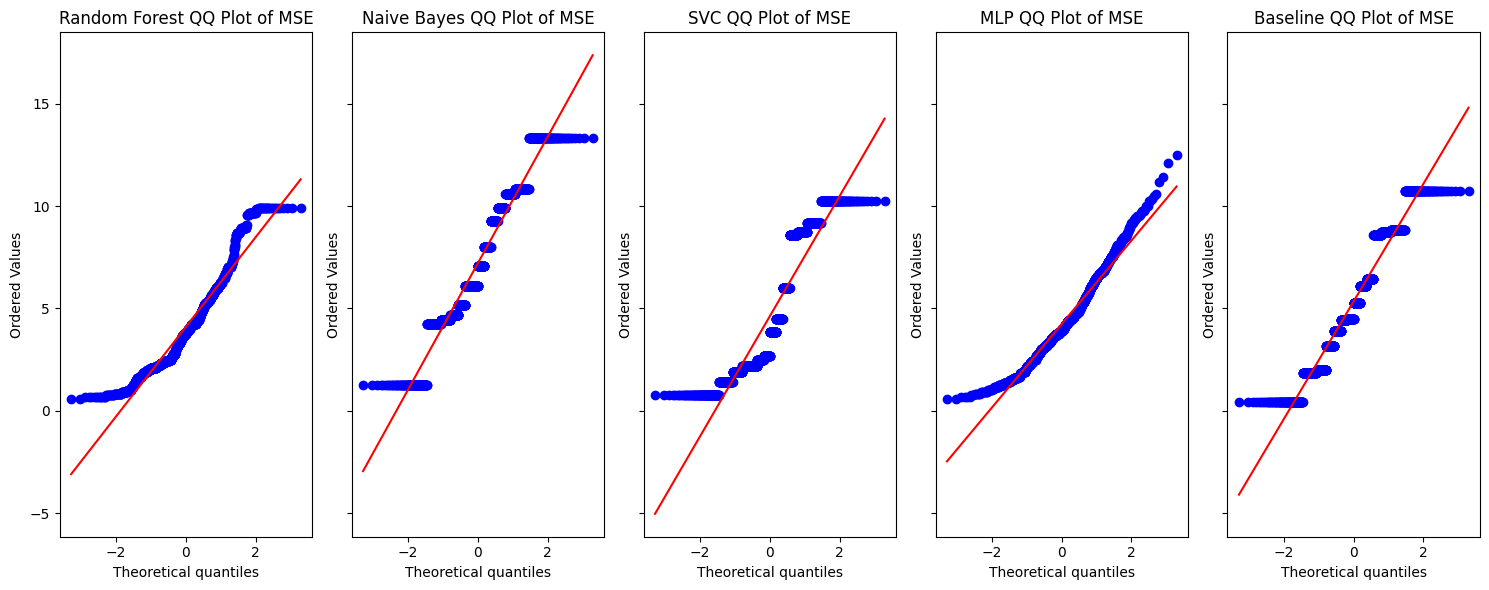

,Model,MSE Shapiro-Wilk Test p-value,F1 Shapiro-Wilk Test p-value
0,Random Forest,7.055834e-24,3.800869e-22
1,Naive Bayes,1.623297e-21,6.968905e-34
2,SVC,1.817153e-34,4.680514e-34
3,MLP,1.950432e-17,1.580761e-21
4,Baseline,1.555025e-22,4.542189e-48


In [13]:
from scipy import stats

shapiro_results = []

fig, axs = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 6), sharey=True)

for (model, metric, f1), ax in zip(metric_iterators, axs.flatten()):
    stats.probplot(metric, dist="norm", plot=ax)
    ax.set_title(f"{model} QQ Plot of {_METRIC_NAME_}")


    shapiro_test = stats.shapiro(metric)
    print(f"{model} - Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
    print(f"{model} - Shapiro-Wilk Test p-value:", shapiro_test.pvalue)


    if shapiro_test.pvalue > 0.05:
        print(f"{model} - The data is normally distributed (fail to reject H0)")
    else:
        print(f"{model} - The data is not normally distributed (reject H0)")

    shapiro_results.append({
        'Model': model,
        f'{_METRIC_NAME_} Shapiro-Wilk Test p-value': shapiro_test.pvalue,
        f'{_METRIC2_NAME_} Shapiro-Wilk Test p-value': stats.shapiro(f1).pvalue if f1 else 'N/A'
    })

plt.tight_layout()
plt.savefig('plots/qqplots.png')
plt.show()


shapiro_df = pd.DataFrame(shapiro_results)
with open('tables/shapiro.txt', 'w') as f:
    f.write(shapiro_df.to_latex())

shapiro_df

In [14]:
from scipy.stats import kruskal

kruskal_test = kruskal(*metrics)
print(f"{_METRIC_NAME_} Kruskal-Wallis H Test Statistic:", kruskal_test.statistic)
print(f"{_METRIC_NAME_} Kruskal-Wallis H Test p-value:", kruskal_test.pvalue)

print('\n')

kruskal_test_f1 = kruskal(*f1_list)
print(f"{_METRIC2_NAME_} Kruskal-Wallis H Test Statistic:", kruskal_test_f1.statistic)
print(f"{_METRIC2_NAME_} Kruskal-Wallis H Test p-value:", kruskal_test_f1.pvalue)

if kruskal_test.pvalue > 0.05:
    print("No significant difference between the models (fail to reject H0)")
else:
    print("Significant difference between the models (reject H0)")


MSE Kruskal-Wallis H Test Statistic: 925.9786894393844
MSE Kruskal-Wallis H Test p-value: 3.9155287356091723e-199


F1 Kruskal-Wallis H Test Statistic: 316.4371790381197
F1 Kruskal-Wallis H Test p-value: 3.079877262859069e-67
Significant difference between the models (reject H0)


In [15]:
from scipy.stats import wilcoxon

p_val_matrix = np.zeros((5, 5))

for model, metric in zip(models, metrics):

    for model2, metric2 in zip(models, metrics):
        if model == model2:
            continue

        print(f"Comparing {model} and {model2}")


        wilcoxon_test = wilcoxon(metric, metric2)
        print("Wilcoxon Test Statistic:", wilcoxon_test.statistic)
        print("Wilcoxon Test p-value:", wilcoxon_test.pvalue)

        print('\n')

        wilcoxon_test_f1 = wilcoxon(f1_list[models.index(model)], f1_list[models.index(model2)])
        print("F1 Wilcoxon Test Statistic:", wilcoxon_test_f1.statistic)
        print("F1 Wilcoxon Test p-value:", wilcoxon_test_f1.pvalue)

        print('\n')


        if wilcoxon_test.pvalue > 0.05:
            print(f"No significant difference between the {_METRIC_NAME_} of the two models (fail to reject H0)")
        else:
            print(f"Significant difference between the {_METRIC_NAME_} of the two models (reject H0)")
        print('\n')
        p_val_matrix[models.index(model), models.index(model2)] = wilcoxon_test.pvalue


Comparing Random Forest and Naive Bayes
Wilcoxon Test Statistic: 142298.5
Wilcoxon Test p-value: 6.130497430576935e-115


F1 Wilcoxon Test Statistic: 412150.0
F1 Wilcoxon Test p-value: 2.3557704542859888e-07


Significant difference between the MSE of the two models (reject H0)


Comparing Random Forest and SVC
Wilcoxon Test Statistic: 398021.0
Wilcoxon Test p-value: 6.481090815936141e-06


F1 Wilcoxon Test Statistic: 341358.0
F1 Wilcoxon Test p-value: 2.0183059858611144e-22


Significant difference between the MSE of the two models (reject H0)


Comparing Random Forest and MLP
Wilcoxon Test Statistic: 420707.0
Wilcoxon Test p-value: 0.0013439631474388228


F1 Wilcoxon Test Statistic: 411795.5
F1 Wilcoxon Test p-value: 0.01552111709324226


Significant difference between the MSE of the two models (reject H0)


Comparing Random Forest and Baseline
Wilcoxon Test Statistic: 217740.0
Wilcoxon Test p-value: 6.121065695359977e-68


F1 Wilcoxon Test Statistic: 264476.0
F1 Wilcoxon Test p-valu

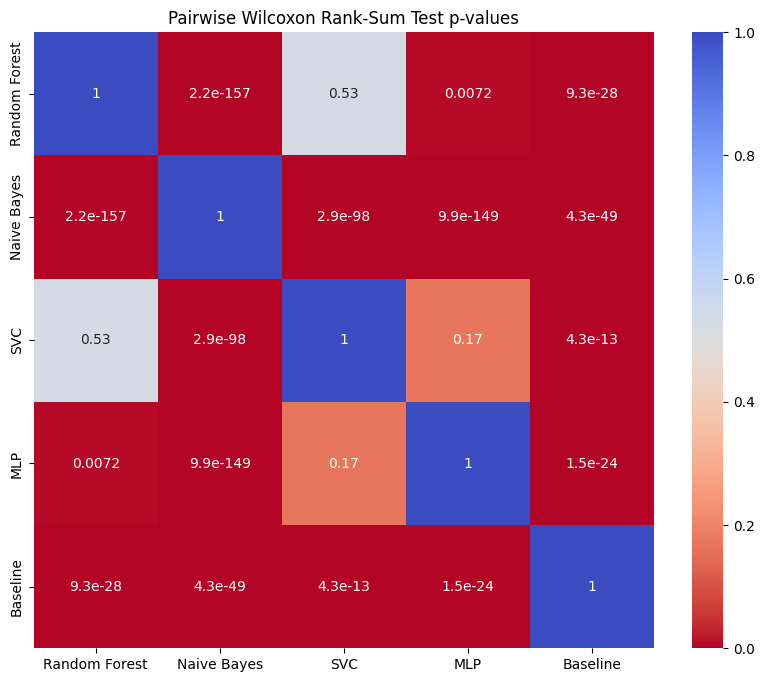

In [62]:

p_val_matrix = np.ones((len(models), len(models))) 
from scipy.stats import ranksums

for i, metric in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i == j:
            continue
        wilcoxon_test = ranksums(metric, metric2)
        p_val_matrix[i, j] = wilcoxon_test.pvalue

plt.figure(figsize=(10, 8))
sns.heatmap(p_val_matrix, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True)
plt.title('Pairwise Wilcoxon Rank-Sum Test p-values')
plt.savefig('plots/pairwise_wilcoxon_pvalues.png')
plt.show()

In [17]:
mean_metrics = [np.mean(m) for m in metrics]
std_metrics = [np.std(m) for m in metrics]

f1_mean_metrics = [np.mean(m) for m in f1_list]
f1_std_metrics = [np.std(m) for m in f1_list]

df = pd.DataFrame(
    np.array(
        [mean_metrics, std_metrics, f1_mean_metrics, f1_std_metrics]).T, index=models, columns=[f'Mean {_METRIC_NAME_ }', 
                                                               f'{_METRIC_NAME_} Standard Deviation',
                                                               f'Mean {_METRIC2_NAME_}',
                                                               f'{_METRIC2_NAME_} Standard Deviation']
    )
df

,Mean MSE,MSE Standard Deviation,Mean F1,F1 Standard Deviation
Random Forest,4.104940,2.252427,0.182946,0.130141
Naive Bayes,7.208333,3.155486,0.149881,0.147049
SVC,4.619048,3.168658,0.145293,0.132876
MLP,4.242143,2.067832,0.188940,0.129482
Baseline,5.351190,2.943950,0.144824,0.188260


Model: Random Forest
MSE 95% Confidence Interval: [3.988, 4.224]
F1 95% Confidence Interval: [0.176, 0.190]


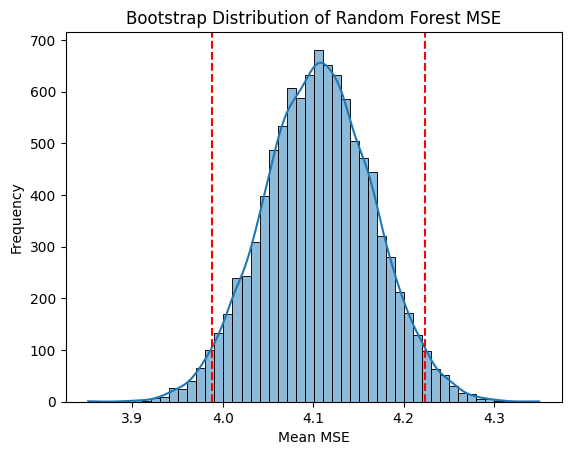

C:\Users\pvest\AppData\Local\Temp\ipykernel_1852\1273276503.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ci_df = pd.concat([ci_df, confidence_intervals])


Model: Naive Bayes
MSE 95% Confidence Interval: [7.042, 7.375]
F1 95% Confidence Interval: [0.142, 0.158]


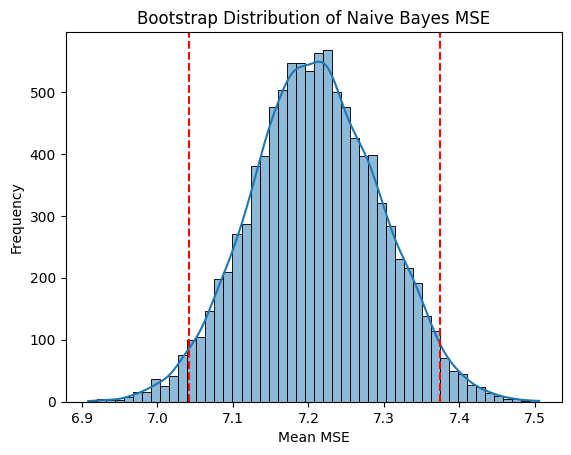

Model: SVC
MSE 95% Confidence Interval: [4.454, 4.790]
F1 95% Confidence Interval: [0.138, 0.152]


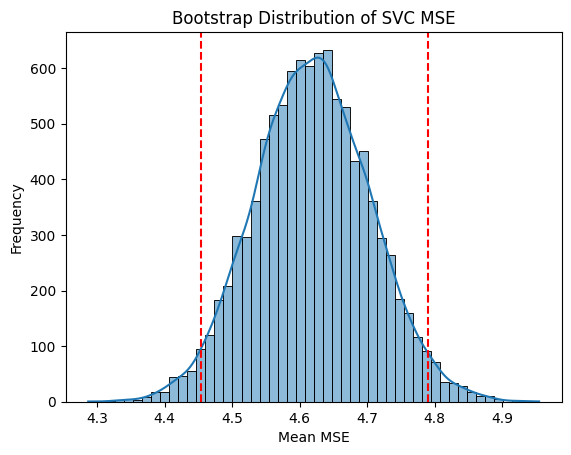

Model: MLP
MSE 95% Confidence Interval: [4.133, 4.352]
F1 95% Confidence Interval: [0.182, 0.196]


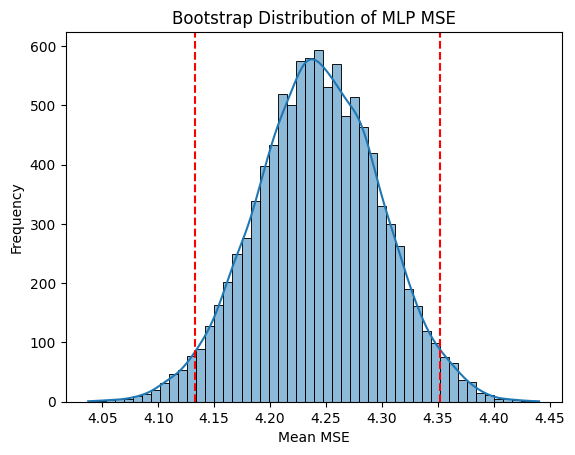

Model: Baseline
MSE 95% Confidence Interval: [5.196, 5.506]
F1 95% Confidence Interval: [0.135, 0.155]


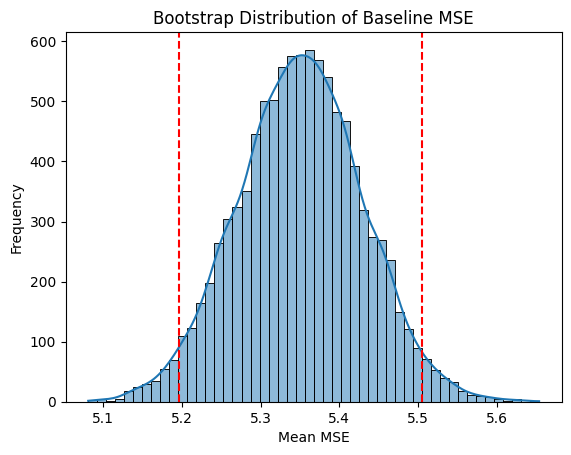

In [63]:
ci_df = pd.DataFrame(columns=['Model', f'{_METRIC_NAME_} Lower Bound', f'{_METRIC_NAME_} Upper Bound', f'{_METRIC_NAME_} Mean', f'{_METRIC_NAME_} Standard Deviation',
                              'F1 Lower Bound', 'F1 Upper Bound', 'F1 Mean', 'F1 Standard Deviation'])
for model, metric, f1 in zip(models, metrics, f1_list):
    n_bootstraps = 10_000
    bootstrapped_accuracies = []
    bootstrapped_f1_scores = []

    for _ in range(n_bootstraps):
        bootstrapped_sample_metric = np.random.choice(metric, size=len(metric), replace=True)
        bootstrapped_accuracies.append(np.mean(bootstrapped_sample_metric))

    for _ in range(n_bootstraps):
        bootstrapped_sample_f1 = np.random.choice(f1, size=len(f1), replace=True)
        bootstrapped_f1_scores.append(np.mean(bootstrapped_sample_f1))

    alpha = 0.95
    lower_bound_metric = np.percentile(bootstrapped_accuracies, (1 - alpha) / 2 * 100)
    upper_bound_metric = np.percentile(bootstrapped_accuracies, (1 + alpha) / 2 * 100)

    lower_bound_f1 = np.percentile(bootstrapped_f1_scores, (1 - alpha) / 2 * 100)
    upper_bound_f1 = np.percentile(bootstrapped_f1_scores, (1 + alpha) / 2 * 100)

    print(f"Model: {model}")
    print(f"{_METRIC_NAME_} 95% Confidence Interval: [{lower_bound_metric:.3f}, {upper_bound_metric:.3f}]")

    print(f"F1 95% Confidence Interval: [{lower_bound_f1:.3f}, {upper_bound_f1:.3f}]")

    sns.histplot(bootstrapped_accuracies, bins=50, kde=True)
    plt.axvline(lower_bound_metric, color='red', linestyle='--')
    plt.axvline(upper_bound_metric, color='red', linestyle='--')
    plt.title(f'Bootstrap Distribution of {model} {_METRIC_NAME_}')
    plt.xlabel(f'Mean {_METRIC_NAME_}')
    plt.ylabel('Frequency')
    plt.savefig(f'plots/{model}_bootstrap_ci.png')
    plt.show()

    confidence_intervals = pd.DataFrame({
        'Model': [model],
        f'{_METRIC_NAME_} Lower Bound': [lower_bound_metric],
        f'{_METRIC_NAME_} Upper Bound': [upper_bound_metric],
        f'{_METRIC_NAME_} Mean': [np.mean(bootstrapped_sample_metric)],
        f'{_METRIC_NAME_} Standard Deviation': [np.std(metric)],
        'F1 Lower Bound': [lower_bound_f1],
        'F1 Upper Bound': [upper_bound_f1],
        'F1 Mean': [np.mean(bootstrapped_sample_f1)],
        'F1 Standard Deviation': [np.std(f1)]
    })

    ci_df = pd.concat([ci_df, confidence_intervals])



ci_df = ci_df.set_index('Model')

ci_df = ci_df.sort_values(by=f'{_METRIC_NAME_} Mean', ascending=True)
ci_df.to_latex('tables/conf_int.txt', float_format="%.4f", bold_rows=True)

In [57]:
ci_df.columns = ['MSE Lwr', 'MSE Upr', 'MSE Mean', 'MSE Std', 'F1 Lwr', 'F1 Upr', 'F1 Mean', 'F1 Std']
ci_df.to_latex('tables/conf_int_2.txt', index=True, float_format="%.5f")

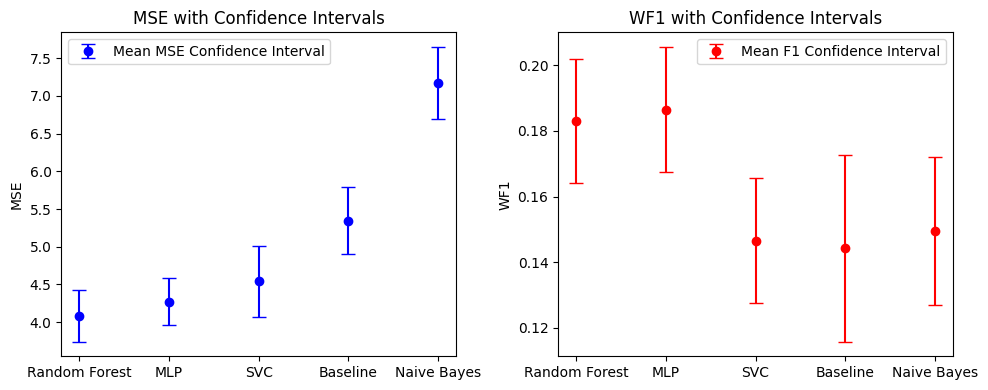

,MSE Lwr,MSE Upr,MSE Mean,MSE Std,F1 Lwr,F1 Upr,F1 Mean,F1 Std
Model,,,,,,,,
Random Forest,3.930057,4.271848,4.085060,2.252427,0.173458,0.192305,0.182919,0.130141
MLP,4.088749,4.398990,4.273631,2.067832,0.179607,0.198637,0.186507,0.129482
SVC,4.385476,4.854291,4.539940,3.168658,0.135653,0.154813,0.146621,0.132876
Baseline,5.131902,5.574109,5.346786,2.943950,0.131193,0.159662,0.144326,0.188260
Naive Bayes,6.972913,7.448757,7.172202,3.155486,0.139058,0.161551,0.149596,0.147049


In [60]:
mse_lower_bounds = ci_df[f'{_METRIC_NAME_} Lwr'].values
mse_upper_bounds = ci_df[f'{_METRIC_NAME_} Upr'].values
mse_means = ci_df[f'{_METRIC_NAME_} Mean'].values
mse_std_devs = ci_df[f'{_METRIC_NAME_} Std'].values

f1_lower_bounds = ci_df['F1 Lwr'].values
f1_upper_bounds = ci_df['F1 Upr'].values
f1_means = ci_df['F1 Mean'].values
f1_std_devs = ci_df['F1 Std'].values

ci_spreads = mse_upper_bounds - mse_lower_bounds
ci_spreads_f1 = f1_upper_bounds - f1_lower_bounds

sorted_models = ci_df.index


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.errorbar(sorted_models, mse_means, yerr=ci_spreads, fmt='o', color='blue', label='Mean MSE Confidence Interval', capsize=5)


ax2.errorbar(sorted_models, f1_means, yerr=ci_spreads_f1, fmt='o', color='red', label='Mean F1 Confidence Interval', capsize=5)

ax1.set_title('MSE with Confidence Intervals')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.set_title('WF1 with Confidence Intervals')
ax2.set_ylabel('WF1')
ax2.legend()
plt.tight_layout()
plt.savefig('plots/confidence_intervals.png')
plt.show()

wilcoxon(nbf1, basef1)
ci_df